<a href="https://colab.research.google.com/github/cralji/RFF-Nerve-UTP/blob/main/FCN__Brachial-Plexus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score, classification_report, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression,  SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import RFE, SelectKBest, chi2
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler
from xml.etree import cElementTree as ElementTree
from keras_preprocessing.image import ImageDataGenerator
from sklearn.externals.six import StringIO  
from sklearn.naive_bayes import GaussianNB
from pandas.plotting import scatter_matrix
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from IPython.display import Image  
import matplotlib.pyplot as plt
from sklearn import metrics 
from joblib import dump, load
import requests, zipfile, io
from sklearn import svm
import numpy as np
from numpy import mean, std
import seaborn as sns
import cv2
import scipy.io
import pandas as pd
import pydotplus
import os
from glob import glob
from PIL import Image
from math import sqrt
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam,SGD
import skimage
from skimage import segmentation

try:
  !pip install scikit-image
except:
  None

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Functions 

In [ ]:
#%% functionfor extract the image's mask from xml extensión file. 
def fun2(pathxml,pathimg, img_path, label_path,img_path_nerve, label_path_nerve):
  tree = ElementTree.parse(pathxml)
  root = tree.getroot()
  xy=[]
  d={}
  i=0
  for element in root:
    if len(element)==0:
      d[str(element.tag)]=str(element.text)
    else: 
      d[str(element.tag)]={}
    for sub in element:
      if len(sub)==0:
        d[str(element.tag)][str(sub.tag)]=str(sub.text)
      else:
        d[str(element.tag)][str(sub.tag)]={}
      for sub2 in sub:
        if len(sub2)==0:
          d[str(element.tag)][str(sub.tag)][str(sub2.tag)]=str(sub2.text)
        else:
          if str(sub2.tag)=="pt":
            i+=1
            d[str(element.tag)][str(sub.tag)][str(sub2.tag)+str(i)]={"x":sub2[0].text,"y":sub2[1].text}
            xy.append((sub2[0].text,sub2[1].text))
  pts = np.asarray(xy,np.int32)
  img=plt.imread(pathimg)
  img_poly = plt.imread(pathimg)
  img_labels = np.zeros((img[:,:,0].shape),dtype=np.uint8)
  cv2.fillPoly(img_poly,[pts], (255,0,0));  
  indices=np.where(np.all(img_poly== (255,0,0),axis=-1)) 
  img_labels[indices[0],indices[1]] = 1#255#255#1
  
  cv2.imwrite(img_path, img)
  cv2.imwrite(label_path, img_labels)

  cv2.imwrite(img_path_nerve, img)
  cv2.imwrite(label_path_nerve, img_labels)

# Load Data

## Download Dataset

In [ ]:
FILEID = "1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O train.zip && rm -rf /tmp/cookies.txt


FILEID = "1mi69Hm_1L0ZfbtKaJbuzfymS3EubsKPy"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O test.zip && rm -rf /tmp/cookies.txt

--2021-08-18 17:06:39--  https://docs.google.com/uc?export=download&confirm=ZcWU&id=1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH
Resolving docs.google.com (docs.google.com)... 74.125.195.138, 74.125.195.102, 74.125.195.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-00-docs.googleusercontent.com/docs/securesc/j9sga5ur3liiij45h4g67vlpt4ibhlp4/daqp9g43afksnbvdq57d8238v0r0iuhp/1629306375000/05137136237839183901/11663560777132467156Z/1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH?e=download [following]
--2021-08-18 17:06:39--  https://doc-10-00-docs.googleusercontent.com/docs/securesc/j9sga5ur3liiij45h4g67vlpt4ibhlp4/daqp9g43afksnbvdq57d8238v0r0iuhp/1629306375000/05137136237839183901/11663560777132467156Z/1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH?e=download
Resolving doc-10-00-docs.googleusercontent.com (doc-10-00-docs.googleusercontent.com)... 74.125.197.132, 2607:f8b0:400e:c03::84
Connecting

In [ ]:
!mkdir train
!mkdir test
!unzip -q train.zip -d train
!unzip -q test.zip -d test

In [ ]:
files_path = glob('./train/*.tif')
files_path = [filepath_ for filepath_ in files_path if 'mask' not in filepath_]
files_mask = [files[:-4]+'_mask.tif' for files in files_path]

# files_path_test = glob('./test/*.tif')
# files_path_test = [filepath_ for filepath_ in files_path_test if 'mask' not in filepath_]
# files_mask_test = [files[:-4]+'_mask.tif' for files in files_path_test]

In [ ]:
void = [np.unique(cv2.imread(mask,cv2.IMREAD_GRAYSCALE)).size==2 for mask in files_mask]
print('All have nerve in train?: {}'.format(np.all(void)))

All have nerve in train?: False


In [ ]:
for_test_files,for_test_mask = [files for c,files in zip(void,files_path) if not(c)],[mask for c,mask in zip(void,files_mask) if not(c)]
files_path,files_mask = [files for c,files in zip(void,files_path) if c],[mask for c,mask in zip(void,files_mask) if c]

# df_train = pd.DataFrame({'filepath':files_path,'mask':files_mask})
# df_test_images = pd.DataFrame({'filepath':files_path_test + for_test_files,'mask':files_mask_test+for_test_mask})

### Split sets

In [ ]:
files_path,files_path_test,files_mask,files_mask_test = train_test_split(np.array(files_path),
                                                                         np.array(files_mask),
                                                                         test_size=0.2)
df_train = pd.DataFrame({'filepath':files_path.tolist(),'mask':files_mask.tolist()})
df_test_images = pd.DataFrame({'filepath':files_path_test.tolist(),
                               'mask':files_mask_test.tolist()})

In [ ]:
df_test_images

,filepath,mask
0,./train/37_101.tif,./train/37_101_mask.tif
1,./train/12_105.tif,./train/12_105_mask.tif
2,./train/27_112.tif,./train/27_112_mask.tif
3,./train/20_104.tif,./train/20_104_mask.tif
4,./train/46_38.tif,./train/46_38_mask.tif
...,...,...
460,./train/9_26.tif,./train/9_26_mask.tif
461,./train/41_28.tif,./train/41_28_mask.tif
462,./train/44_32.tif,./train/44_32_mask.tif
463,./train/18_29.tif,./train/18_29_mask.tif


In [ ]:
df_train_images,df_val_images = train_test_split(df_train, test_size=0.2)
# df_train_images,df_val_images = train_test_split(df_train_images, test_size=0.2)

In [ ]:
def preprocessing_mask(mask):
  mask[mask > 0.5] = 255
  mask[mask <= 0.5] = 0
  return mask

In [ ]:
seed = 1993
batch_size = 32
height,width = 128,128
image_datagen = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip =True,
                                   vertical_flip=True,
                                   rescale=1./255)

image_datagen_mask = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip =True,
                                   vertical_flip=True,
                                   rescale=1./255,
                                   preprocessing_function = preprocessing_mask)

generator_train_img = image_datagen.flow_from_dataframe(df_train_images,
                                                        x_col = 'filepath',
                                                        batch_size = batch_size,
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        seed = seed)

generator_train_mask = image_datagen_mask.flow_from_dataframe(df_train_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale", 
                                                         batch_size = batch_size,
                                                         target_size = (height,width),
                                                         seed = seed)

train_gen = zip(generator_train_img,generator_train_mask)


generator_val_img = image_datagen.flow_from_dataframe(df_val_images,
                                                        x_col='filepath',
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        batch_size = batch_size,
                                                        seed = seed)

generator_val_mask = image_datagen_mask.flow_from_dataframe(df_val_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale",
                                                         target_size = (height,width),
                                                         batch_size = batch_size,
                                                         seed = seed)

val_gen = zip(generator_val_img,generator_val_mask)


generator_test_img = image_datagen.flow_from_dataframe(df_test_images,
                                                        x_col='filepath',
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        batch_size = batch_size,
                                                        seed = seed)

generator_test_mask = image_datagen_mask.flow_from_dataframe(df_test_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale",
                                                         target_size = (height,width),
                                                         batch_size = batch_size,
                                                         seed = seed)

test_gen = zip(generator_test_img,generator_test_mask)


Found 1486 validated image filenames.
Found 1486 validated image filenames.
Found 372 validated image filenames.
Found 372 validated image filenames.
Found 465 validated image filenames.
Found 465 validated image filenames.


Shape_in: (32, 128, 128, 3)


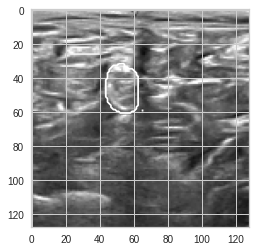

array([0., 1.], dtype=float32)

In [ ]:
i,j = next(test_gen)
print('Shape_in: {}'.format(i.shape))
plt.imshow(i[0,:,:,:])
edges_est = segmentation.clear_border(j[0,:,:,0])
plt.contour(edges_est,[0.5])
plt.show()
np.unique(j[0,:,:,0])

# Build Model 

## need functions

In [ ]:
def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def renny_entropy(ytrue,ypred):
    Ke = tf.matmul(ypred,ypred,transpose_b=True)
    Ke = Ke/tf.linalg.trace(Ke)
    #entropy_renny  = (1/(1-2))*tf.math.log((1/tf.constant(32*32,dtype=ypred.dtype))*tf.linalg.trace(tf.matmul(Ke,Ke,transpose_a=True)))
    entropy_renny = tf.constant(1/(1-2))*tf.linalg.trace(tf.matmul(Ke,Ke,transpose_a=True))
    return entropy_renny


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred, smooth = 1.):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def sensitivity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
   
    true_positives = K.sum(K.round(K.clip(y_true_c * y_pred_c, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true_c, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
    
    true_negatives = K.sum(K.round(K.clip((1-y_true_c) * (1-y_pred_c), 0, 1)))#123456789
# path = "./ImagenesNervios/data/"data_image = [] data_mask = glob(path + '*_mask*') for i in data_mask:  data_image.append(i.replace('_mask', '')) print("Cantidad total de datos:",len(data_image))

    possible_negatives = K.sum(K.round(K.clip(1-y_true_c, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.layers.experimental import RandomFourierFeatures
GAUSSIAN_NOISE = 0.1
ACTIVATION = 'relu'
def fcn(image_size,ch_in=3, ch_out=1):
    
    # inputs = Input(shape=(*image_size, ch_in), name='input')

    # # Building a pre-trained VGG-16 feature extractor (i.e., without the final FC layers)
    # vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    # # Recovering the feature maps generated by each of the 3 final blocks:
    # f3 = vgg16.get_layer('block3_pool').output  
    # f4 = vgg16.get_layer('block4_pool').output  
    # f5 = vgg16.get_layer('block5_pool').output  

    # Replacing VGG dense layers by convolutions:

    inputs = Input((*image_size, ch_in), name = 'RGB_Input')
    gn_inputs = GaussianNoise(GAUSSIAN_NOISE)(inputs)
    bn_inputs = BatchNormalization()(gn_inputs)
    f1 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (bn_inputs)

    f1 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (f1)
    f1 = BatchNormalization()(f1)
    f1 = MaxPooling2D((2, 2)) (f1)

    f2 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (f1)#(inputs)
    f2 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (f2)
    f2 = BatchNormalization()(f2)
    f2 = MaxPooling2D((2, 2)) (f2)

    f3 = Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (f2)#(inputs)
    f3 = Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (f3)
    f3 = BatchNormalization()(f3)
    f3 = MaxPooling2D((2, 2)) (f3)

    f4 = Conv2D(128, (3, 3), activation=ACTIVATION, padding='same') (f3)
    f4 = Conv2D(128, (3, 3), activation=ACTIVATION, padding='same') (f4)
    f4 = BatchNormalization()(f4)
    f4 = MaxPooling2D((2, 2)) (f4)

    f5 = Conv2D(256, (3, 3), activation=ACTIVATION, padding='same') (f4)
    f5 = Conv2D(256, (3, 3), activation=ACTIVATION, padding='same') (f5)
    f5 = BatchNormalization()(f5)
    f5 = MaxPooling2D((2, 2)) (f5)


    #%% Modified by CAJ
    # flatten = Flatten()(f5)
    # rff = RandomFourierFeatures(output_dim=int(height/32)*int(width/32)*phi_units,trainable=True,name = 'Phi')(flatten)
    # resha = Reshape((int(height/32),int(width/32),-1))(rff)
    # f6 = Conv2D(ch_out, (1, 1), activation=ACTIVATION, padding='same') (resha)
    #%% End modify
    
    # f5_conv1 = Conv2D(filters=4086, kernel_size=7, padding='same',
    #                   activation='relu')(resha)#(f5)
    # f5_drop1 = Dropout(0.5)(f5_conv1)
    # f5_conv2 = Conv2D(filters=4086, kernel_size=1, padding='same',
    #                   activation='relu')(f5_drop1)
    # f5_drop2 = Dropout(0.5)(f5_conv2)
    # f5_conv3 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
    #                   activation=None)(f5_drop2)
    

    # Using a transposed conv (w/ s=2) to upscale `f5` into a 14 x 14 map
    # so it can be merged with features from `f4_conv1` obtained from `f4`:
    f5_conv3_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(f5) #(resha)
    f4_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f4)

    # Merging the 2 feature maps (addition):
    merge1 = add([f4_conv1,f5_conv3_x2])

    # We repeat the operation to merge `merge1` and `f3` into a 28 x 28 map:
    merge1_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(merge1)
    f3_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f3)
    merge2 = add([f3_conv1, merge1_x2])

    # Finally, we use another transposed conv to decode and up-scale the feature map
    # to the original shape, i.e., using a stride 8 to go from 28 x 28 to 224 x 224 here:
    outputs = Conv2DTranspose(filters=1, kernel_size=16, strides=8,
                              padding='same', activation='sigmoid',name='output')(merge2)
    
    fcn_model = Model(inputs, outputs)
    return fcn_model

seg_model = fcn((128,128),1)

seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 128, 128, 1)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 1)  4           gaussian_noise[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         batch_normalization[0][0]        
______________________________________________________________________________________________

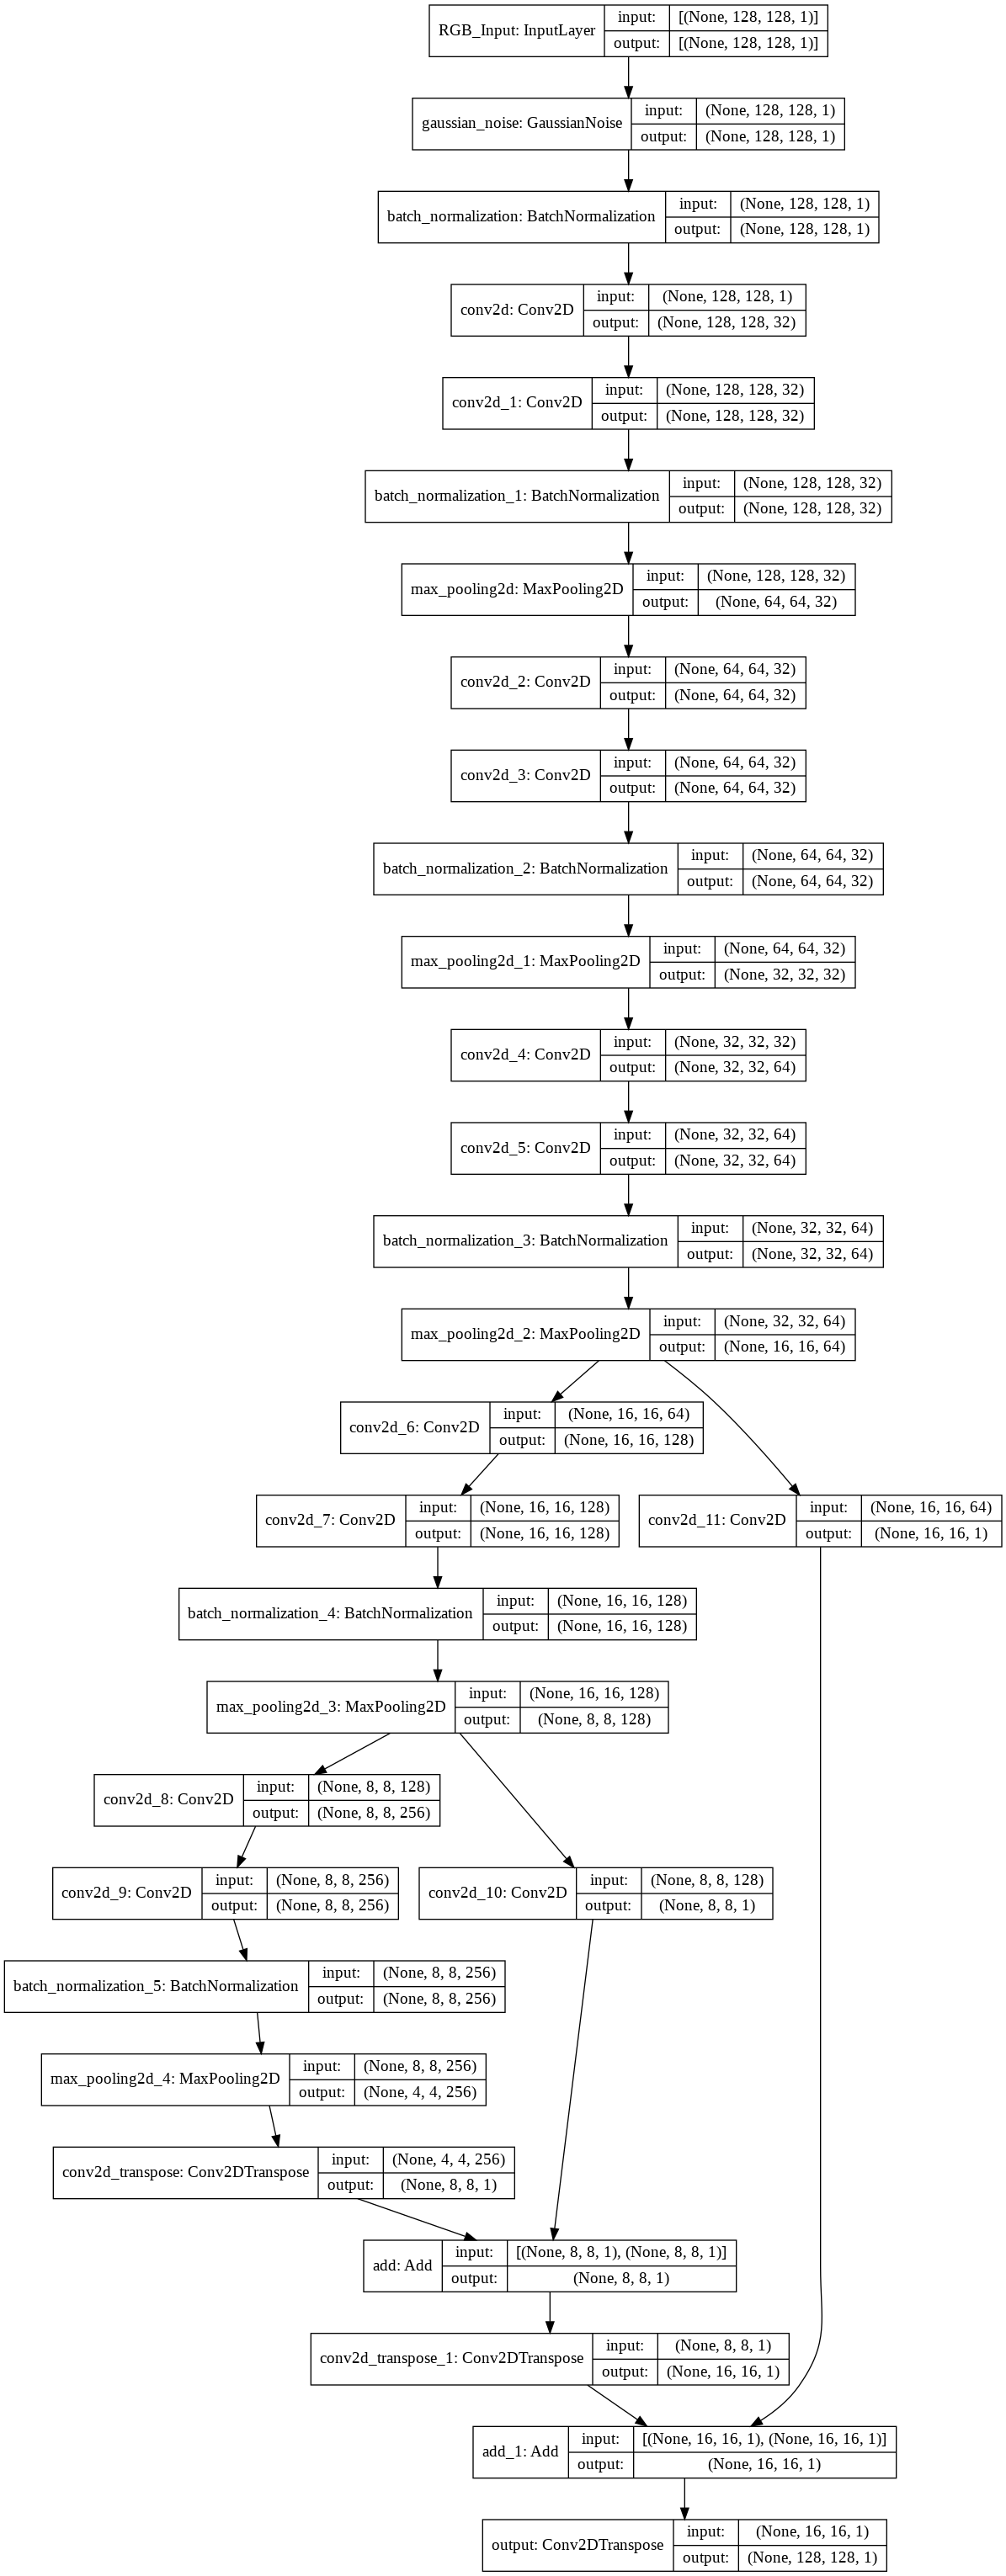

In [ ]:
tf.keras.utils.plot_model(seg_model,show_shapes=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 39s 479ms/step - loss: -0.0653 - iou: 0.0337 - dice_coef: 0.0653 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.4971 - val_loss: -0.0614 - val_iou: 0.0317 - val_dice_coef: 0.0614 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.6440


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 2/200
 1/46 [..............................] - ETA: 1s - loss: -0.0604 - iou: 0.0311 - dice_coef: 0.0604 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.4825

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 477ms/step - loss: -0.0778 - iou: 0.0405 - dice_coef: 0.0779 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.5470 - val_loss: -0.0607 - val_iou: 0.0313 - val_dice_coef: 0.0607 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.7739


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 3/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 477ms/step - loss: -0.1003 - iou: 0.0528 - dice_coef: 0.1003 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.6726 - val_loss: -0.0587 - val_iou: 0.0302 - val_dice_coef: 0.0587 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.8806


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 4/200
 1/46 [..............................] - ETA: 0s - loss: -0.0856 - iou: 0.0447 - dice_coef: 0.0856 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7209

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 480ms/step - loss: -0.1347 - iou: 0.0720 - dice_coef: 0.1341 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7947 - val_loss: -0.0543 - val_iou: 0.0279 - val_dice_coef: 0.0543 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9377


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 5/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 477ms/step - loss: -0.1914 - iou: 0.1059 - dice_coef: 0.1911 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8910 - val_loss: -0.0484 - val_iou: 0.0248 - val_dice_coef: 0.0484 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9635


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 6/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 472ms/step - loss: -0.2931 - iou: 0.1722 - dice_coef: 0.2925 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9436 - val_loss: -0.0242 - val_iou: 0.0123 - val_dice_coef: 0.0242 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9668


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 7/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 466ms/step - loss: -0.4221 - iou: 0.2685 - dice_coef: 0.4213 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9657 - val_loss: -0.0119 - val_iou: 0.0060 - val_dice_coef: 0.0119 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9671


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 8/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 476ms/step - loss: -0.5146 - iou: 0.3479 - dice_coef: 0.5143 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9721 - val_loss: -0.0277 - val_iou: 0.0141 - val_dice_coef: 0.0277 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9674


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 9/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 469ms/step - loss: -0.5791 - iou: 0.4093 - dice_coef: 0.5792 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9753 - val_loss: -0.1370 - val_iou: 0.0743 - val_dice_coef: 0.1370 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9687


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 10/200
 1/46 [..............................] - ETA: 1s - loss: -0.2281 - iou: 0.1287 - dice_coef: 0.2281 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9474

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 475ms/step - loss: -0.6034 - iou: 0.4349 - dice_coef: 0.6040 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9760 - val_loss: -0.4220 - val_iou: 0.2685 - val_dice_coef: 0.4220 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9722


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 11/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 472ms/step - loss: -0.6336 - iou: 0.4673 - dice_coef: 0.6344 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9776 - val_loss: -0.4548 - val_iou: 0.2962 - val_dice_coef: 0.4548 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9745


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 12/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 468ms/step - loss: -0.6451 - iou: 0.4784 - dice_coef: 0.6449 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9782 - val_loss: -0.4942 - val_iou: 0.3319 - val_dice_coef: 0.4942 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9750


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 13/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 466ms/step - loss: -0.6629 - iou: 0.4991 - dice_coef: 0.6635 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9792 - val_loss: -0.5349 - val_iou: 0.3683 - val_dice_coef: 0.5349 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9764


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 14/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 473ms/step - loss: -0.6685 - iou: 0.5064 - dice_coef: 0.6686 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9794 - val_loss: -0.5422 - val_iou: 0.3773 - val_dice_coef: 0.5422 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9764


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 15/200
 1/46 [..............................] - ETA: 1s - loss: -0.1978 - iou: 0.1098 - dice_coef: 0.1978 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9486

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 469ms/step - loss: -0.6757 - iou: 0.5140 - dice_coef: 0.6758 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9798 - val_loss: -0.6241 - val_iou: 0.4590 - val_dice_coef: 0.6241 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/200
46/46 [==============================] - 21s 472ms/step - loss: -0.6841 - iou: 0.5227 - dice_coef: 0.6837 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9805 - val_loss: -0.6053 - val_iou: 0.4388 - val_dice_coef: 0.6053 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9764


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 17/200
 1/46 [..............................] - ETA: 1s - loss: -0.1508 - iou: 0.0815 - dice_coef: 0.1508 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9400

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 476ms/step - loss: -0.6879 - iou: 0.5298 - dice_coef: 0.6887 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9805 - val_loss: -0.6015 - val_iou: 0.4350 - val_dice_coef: 0.6015 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 18/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 477ms/step - loss: -0.6974 - iou: 0.5403 - dice_coef: 0.6976 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9811 - val_loss: -0.6278 - val_iou: 0.4681 - val_dice_coef: 0.6278 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 19/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 23s 502ms/step - loss: -0.7075 - iou: 0.5511 - dice_coef: 0.7079 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9819 - val_loss: -0.6364 - val_iou: 0.4747 - val_dice_coef: 0.6364 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9781


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 20/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 23s 499ms/step - loss: -0.7114 - iou: 0.5554 - dice_coef: 0.7112 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -0.6300 - val_iou: 0.4649 - val_dice_coef: 0.6300 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/200
46/46 [==============================] - 22s 483ms/step - loss: -0.7116 - iou: 0.5550 - dice_coef: 0.7109 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9818 - val_loss: -0.6267 - val_iou: 0.4588 - val_dice_coef: 0.6267 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 22/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 480ms/step - loss: -0.7215 - iou: 0.5673 - dice_coef: 0.7215 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -0.6501 - val_iou: 0.4900 - val_dice_coef: 0.6501 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 23/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 485ms/step - loss: -0.7181 - iou: 0.5627 - dice_coef: 0.7179 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9823 - val_loss: -0.6539 - val_iou: 0.4883 - val_dice_coef: 0.6539 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 24/200
46/46 [==============================] - 22s 479ms/step - loss: -0.7291 - iou: 0.5764 - dice_coef: 0.7294 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -0.6279 - val_iou: 0.4618 - val_dice_coef: 0.6279 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 25/200
46/46 [==============================] - 22s 481ms/step - loss: -0.7274 - iou: 0.5756 - dice_coef: 0.7276 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9829 - val_loss: -0.6425 - val_iou: 0.4837 - val_dice_coef: 0.6425 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 26/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 480ms/step - loss: -0.7361 - iou: 0.5857 - dice_coef: 0.7365 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -0.6369 - val_iou: 0.4738 - val_dice_coef: 0.6369 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 27/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 478ms/step - loss: -0.7338 - iou: 0.5831 - dice_coef: 0.7344 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -0.5914 - val_iou: 0.4329 - val_dice_coef: 0.5914 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 28/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 476ms/step - loss: -0.7422 - iou: 0.5939 - dice_coef: 0.7425 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.6863 - val_iou: 0.5246 - val_dice_coef: 0.6863 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 29/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 478ms/step - loss: -0.7389 - iou: 0.5925 - dice_coef: 0.7397 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -0.6630 - val_iou: 0.5098 - val_dice_coef: 0.6630 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 30/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 479ms/step - loss: -0.7451 - iou: 0.5970 - dice_coef: 0.7441 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.6651 - val_iou: 0.5028 - val_dice_coef: 0.6651 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 31/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 478ms/step - loss: -0.7451 - iou: 0.5966 - dice_coef: 0.7451 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9839 - val_loss: -0.6827 - val_iou: 0.5260 - val_dice_coef: 0.6827 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 32/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 481ms/step - loss: -0.7508 - iou: 0.6046 - dice_coef: 0.7506 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.6670 - val_iou: 0.5110 - val_dice_coef: 0.6670 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 33/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 476ms/step - loss: -0.7476 - iou: 0.6018 - dice_coef: 0.7473 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.6592 - val_iou: 0.5009 - val_dice_coef: 0.6592 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 34/200
46/46 [==============================] - 22s 480ms/step - loss: -0.7583 - iou: 0.6139 - dice_coef: 0.7584 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.6608 - val_iou: 0.4997 - val_dice_coef: 0.6608 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 35/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 478ms/step - loss: -0.7512 - iou: 0.6058 - dice_coef: 0.7516 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -0.6762 - val_iou: 0.5208 - val_dice_coef: 0.6762 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 36/200
 1/46 [..............................] - ETA: 1s - loss: -0.2314 - iou: 0.1308 - dice_coef: 0.2314 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9484

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 478ms/step - loss: -0.7570 - iou: 0.6144 - dice_coef: 0.7572 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.6974 - val_iou: 0.5397 - val_dice_coef: 0.6974 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 37/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 474ms/step - loss: -0.7574 - iou: 0.6146 - dice_coef: 0.7574 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -0.6910 - val_iou: 0.5361 - val_dice_coef: 0.6910 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 38/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 482ms/step - loss: -0.7613 - iou: 0.6200 - dice_coef: 0.7615 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.7046 - val_iou: 0.5527 - val_dice_coef: 0.7046 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 39/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 474ms/step - loss: -0.7611 - iou: 0.6200 - dice_coef: 0.7612 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.7031 - val_iou: 0.5462 - val_dice_coef: 0.7031 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 40/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 477ms/step - loss: -0.7630 - iou: 0.6212 - dice_coef: 0.7625 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.7036 - val_iou: 0.5459 - val_dice_coef: 0.7036 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 41/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 477ms/step - loss: -0.7648 - iou: 0.6226 - dice_coef: 0.7640 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.6612 - val_iou: 0.5078 - val_dice_coef: 0.6612 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 42/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 474ms/step - loss: -0.7667 - iou: 0.6253 - dice_coef: 0.7666 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.7039 - val_iou: 0.5455 - val_dice_coef: 0.7039 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 43/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 473ms/step - loss: -0.7673 - iou: 0.6281 - dice_coef: 0.7673 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.7039 - val_iou: 0.5459 - val_dice_coef: 0.7039 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 44/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 475ms/step - loss: -0.7697 - iou: 0.6315 - dice_coef: 0.7702 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.6688 - val_iou: 0.5163 - val_dice_coef: 0.6688 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 45/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 481ms/step - loss: -0.7722 - iou: 0.6349 - dice_coef: 0.7730 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.6702 - val_iou: 0.5187 - val_dice_coef: 0.6702 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 46/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 475ms/step - loss: -0.7716 - iou: 0.6335 - dice_coef: 0.7723 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.7020 - val_iou: 0.5423 - val_dice_coef: 0.7020 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 47/200
46/46 [==============================] - 22s 480ms/step - loss: -0.7734 - iou: 0.6357 - dice_coef: 0.7735 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.7011 - val_iou: 0.5470 - val_dice_coef: 0.7011 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 48/200
46/46 [==============================] - 21s 475ms/step - loss: -0.7725 - iou: 0.6355 - dice_coef: 0.7727 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.6953 - val_iou: 0.5480 - val_dice_coef: 0.6953 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 49/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 477ms/step - loss: -0.7776 - iou: 0.6408 - dice_coef: 0.7780 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7096 - val_iou: 0.5618 - val_dice_coef: 0.7096 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 50/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 478ms/step - loss: -0.7803 - iou: 0.6446 - dice_coef: 0.7803 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.6917 - val_iou: 0.5444 - val_dice_coef: 0.6917 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 51/200
 1/46 [..............................] - ETA: 1s - loss: -0.3696 - iou: 0.2267 - dice_coef: 0.3696 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9581

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 487ms/step - loss: -0.7889 - iou: 0.6481 - dice_coef: 0.7838 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.7117 - val_iou: 0.5617 - val_dice_coef: 0.7117 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 52/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 476ms/step - loss: -0.7808 - iou: 0.6444 - dice_coef: 0.7806 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -0.7229 - val_iou: 0.5685 - val_dice_coef: 0.7229 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 53/200
 1/46 [..............................] - ETA: 1s - loss: -0.2948 - iou: 0.1729 - dice_coef: 0.2948 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9538

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 480ms/step - loss: -0.7838 - iou: 0.6500 - dice_coef: 0.7845 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7016 - val_iou: 0.5485 - val_dice_coef: 0.7016 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 54/200
46/46 [==============================] - 21s 472ms/step - loss: -0.7836 - iou: 0.6481 - dice_coef: 0.7835 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7028 - val_iou: 0.5514 - val_dice_coef: 0.7028 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 55/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 472ms/step - loss: -0.7827 - iou: 0.6481 - dice_coef: 0.7829 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.6978 - val_iou: 0.5472 - val_dice_coef: 0.6978 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 56/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 482ms/step - loss: -0.7882 - iou: 0.6536 - dice_coef: 0.7881 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7226 - val_iou: 0.5706 - val_dice_coef: 0.7226 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 57/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 476ms/step - loss: -0.7885 - iou: 0.6535 - dice_coef: 0.7880 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7023 - val_iou: 0.5528 - val_dice_coef: 0.7023 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 58/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 481ms/step - loss: -0.7862 - iou: 0.6530 - dice_coef: 0.7867 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7182 - val_iou: 0.5621 - val_dice_coef: 0.7182 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 59/200
46/46 [==============================] - 22s 477ms/step - loss: -0.7960 - iou: 0.6636 - dice_coef: 0.7960 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7014 - val_iou: 0.5522 - val_dice_coef: 0.7014 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 60/200
46/46 [==============================] - 21s 475ms/step - loss: -0.7873 - iou: 0.6551 - dice_coef: 0.7875 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7256 - val_iou: 0.5752 - val_dice_coef: 0.7256 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 61/200
46/46 [==============================] - 21s 472ms/step - loss: -0.7880 - iou: 0.6555 - dice_coef: 0.7879 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7101 - val_iou: 0.5636 - val_dice_coef: 0.7101 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 62/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 478ms/step - loss: -0.7949 - iou: 0.6651 - dice_coef: 0.7954 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.6927 - val_iou: 0.5489 - val_dice_coef: 0.6927 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 63/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 475ms/step - loss: -0.7937 - iou: 0.6642 - dice_coef: 0.7942 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.7195 - val_iou: 0.5713 - val_dice_coef: 0.7195 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 64/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 483ms/step - loss: -0.7935 - iou: 0.6627 - dice_coef: 0.7937 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7003 - val_iou: 0.5570 - val_dice_coef: 0.7003 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 65/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 479ms/step - loss: -0.7920 - iou: 0.6608 - dice_coef: 0.7923 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.7249 - val_iou: 0.5761 - val_dice_coef: 0.7249 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 66/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 478ms/step - loss: -0.7971 - iou: 0.6682 - dice_coef: 0.7974 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.6938 - val_iou: 0.5447 - val_dice_coef: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 67/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 481ms/step - loss: -0.7937 - iou: 0.6645 - dice_coef: 0.7940 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7073 - val_iou: 0.5548 - val_dice_coef: 0.7073 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 68/200
 1/46 [..............................] - ETA: 1s - loss: -0.2883 - iou: 0.1684 - dice_coef: 0.2883 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9539

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 479ms/step - loss: -0.7977 - iou: 0.6688 - dice_coef: 0.7979 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7102 - val_iou: 0.5705 - val_dice_coef: 0.7102 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 69/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 481ms/step - loss: -0.8007 - iou: 0.6727 - dice_coef: 0.8006 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7135 - val_iou: 0.5723 - val_dice_coef: 0.7135 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 70/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 481ms/step - loss: -0.7960 - iou: 0.6680 - dice_coef: 0.7965 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7305 - val_iou: 0.5821 - val_dice_coef: 0.7305 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 71/200
 1/46 [..............................] - ETA: 1s - loss: -0.2999 - iou: 0.1764 - dice_coef: 0.2999 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9551

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 479ms/step - loss: -0.7994 - iou: 0.6712 - dice_coef: 0.7998 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7036 - val_iou: 0.5566 - val_dice_coef: 0.7036 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 72/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 476ms/step - loss: -0.7972 - iou: 0.6686 - dice_coef: 0.7975 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7228 - val_iou: 0.5765 - val_dice_coef: 0.7228 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 73/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 480ms/step - loss: -0.8072 - iou: 0.6806 - dice_coef: 0.8074 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7204 - val_iou: 0.5761 - val_dice_coef: 0.7204 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 74/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 478ms/step - loss: -0.8002 - iou: 0.6739 - dice_coef: 0.8006 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7204 - val_iou: 0.5688 - val_dice_coef: 0.7204 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 75/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 487ms/step - loss: -0.8008 - iou: 0.6731 - dice_coef: 0.8011 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7207 - val_iou: 0.5699 - val_dice_coef: 0.7207 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 76/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 496ms/step - loss: -0.8058 - iou: 0.6812 - dice_coef: 0.8065 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7319 - val_iou: 0.5823 - val_dice_coef: 0.7319 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 77/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 474ms/step - loss: -0.8032 - iou: 0.6773 - dice_coef: 0.8031 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7092 - val_iou: 0.5636 - val_dice_coef: 0.7092 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 78/200
46/46 [==============================] - 22s 478ms/step - loss: -0.8050 - iou: 0.6785 - dice_coef: 0.8053 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7295 - val_iou: 0.5806 - val_dice_coef: 0.7295 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 79/200
 1/46 [..............................] - ETA: 1s - loss: -0.2322 - iou: 0.1314 - dice_coef: 0.2322 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9474

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 456ms/step - loss: -0.8063 - iou: 0.6824 - dice_coef: 0.8068 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7400 - val_iou: 0.5899 - val_dice_coef: 0.7400 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 80/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 468ms/step - loss: -0.8055 - iou: 0.6790 - dice_coef: 0.8055 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7439 - val_iou: 0.5964 - val_dice_coef: 0.7439 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 81/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 462ms/step - loss: -0.8036 - iou: 0.6772 - dice_coef: 0.8039 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7294 - val_iou: 0.5830 - val_dice_coef: 0.7294 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 82/200
 1/46 [..............................] - ETA: 1s - loss: -0.1560 - iou: 0.0846 - dice_coef: 0.1560 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9442

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 467ms/step - loss: -0.8062 - iou: 0.6831 - dice_coef: 0.8064 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.7247 - val_iou: 0.5773 - val_dice_coef: 0.7247 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 83/200
 1/46 [..............................] - ETA: 1s - loss: -0.2594 - iou: 0.1490 - dice_coef: 0.2594 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9523

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 477ms/step - loss: -0.8096 - iou: 0.6856 - dice_coef: 0.8093 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7425 - val_iou: 0.5924 - val_dice_coef: 0.7425 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 84/200
46/46 [==============================] - 22s 479ms/step - loss: -0.8117 - iou: 0.6861 - dice_coef: 0.8112 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7085 - val_iou: 0.5663 - val_dice_coef: 0.7085 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 85/200
46/46 [==============================] - 22s 477ms/step - loss: -0.8103 - iou: 0.6853 - dice_coef: 0.8101 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7229 - val_iou: 0.5768 - val_dice_coef: 0.7229 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 86/200
46/46 [==============================] - 22s 482ms/step - loss: -0.8128 - iou: 0.6887 - dice_coef: 0.8131 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7317 - val_iou: 0.5826 - val_dice_coef: 0.7317 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 87/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 475ms/step - loss: -0.8140 - iou: 0.6915 - dice_coef: 0.8141 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7145 - val_iou: 0.5726 - val_dice_coef: 0.7145 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 88/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 478ms/step - loss: -0.8117 - iou: 0.6886 - dice_coef: 0.8121 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7299 - val_iou: 0.5837 - val_dice_coef: 0.7299 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 89/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 487ms/step - loss: -0.8136 - iou: 0.6899 - dice_coef: 0.8134 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7397 - val_iou: 0.5937 - val_dice_coef: 0.7397 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 90/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 23s 502ms/step - loss: -0.8130 - iou: 0.6902 - dice_coef: 0.8128 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7327 - val_iou: 0.5864 - val_dice_coef: 0.7327 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 91/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 499ms/step - loss: -0.8154 - iou: 0.6949 - dice_coef: 0.8154 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7279 - val_iou: 0.5805 - val_dice_coef: 0.7279 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 92/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 483ms/step - loss: -0.8119 - iou: 0.6899 - dice_coef: 0.8124 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7452 - val_iou: 0.5965 - val_dice_coef: 0.7452 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 93/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 480ms/step - loss: -0.8149 - iou: 0.6941 - dice_coef: 0.8152 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7364 - val_iou: 0.5923 - val_dice_coef: 0.7364 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 94/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 481ms/step - loss: -0.8159 - iou: 0.6946 - dice_coef: 0.8156 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7374 - val_iou: 0.5901 - val_dice_coef: 0.7374 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 95/200
46/46 [==============================] - 22s 478ms/step - loss: -0.8190 - iou: 0.6975 - dice_coef: 0.8190 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7371 - val_iou: 0.5911 - val_dice_coef: 0.7371 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 96/200
46/46 [==============================] - 21s 476ms/step - loss: -0.8156 - iou: 0.6954 - dice_coef: 0.8161 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7413 - val_iou: 0.5949 - val_dice_coef: 0.7413 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 97/200
46/46 [==============================] - 23s 507ms/step - loss: -0.8190 - iou: 0.6988 - dice_coef: 0.8190 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7091 - val_iou: 0.5699 - val_dice_coef: 0.7091 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 98/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 23s 502ms/step - loss: -0.8282 - iou: 0.7030 - dice_coef: 0.8218 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7194 - val_iou: 0.5746 - val_dice_coef: 0.7194 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 99/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 486ms/step - loss: -0.8154 - iou: 0.6961 - dice_coef: 0.8156 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7129 - val_iou: 0.5694 - val_dice_coef: 0.7129 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 100/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 479ms/step - loss: -0.8205 - iou: 0.7013 - dice_coef: 0.8209 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7213 - val_iou: 0.5804 - val_dice_coef: 0.7213 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 101/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 478ms/step - loss: -0.8191 - iou: 0.6999 - dice_coef: 0.8191 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7413 - val_iou: 0.5931 - val_dice_coef: 0.7413 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 102/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 473ms/step - loss: -0.8213 - iou: 0.7028 - dice_coef: 0.8216 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7213 - val_iou: 0.5824 - val_dice_coef: 0.7213 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 103/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 467ms/step - loss: -0.8230 - iou: 0.7049 - dice_coef: 0.8234 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7242 - val_iou: 0.5814 - val_dice_coef: 0.7242 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 104/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 479ms/step - loss: -0.8156 - iou: 0.6967 - dice_coef: 0.8159 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7500 - val_iou: 0.6024 - val_dice_coef: 0.7500 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 105/200
46/46 [==============================] - 22s 480ms/step - loss: -0.8200 - iou: 0.7015 - dice_coef: 0.8201 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7152 - val_iou: 0.5741 - val_dice_coef: 0.7152 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 106/200
46/46 [==============================] - 22s 483ms/step - loss: -0.8209 - iou: 0.7010 - dice_coef: 0.8207 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7333 - val_iou: 0.5874 - val_dice_coef: 0.7333 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 107/200
46/46 [==============================] - 22s 484ms/step - loss: -0.8252 - iou: 0.7087 - dice_coef: 0.8255 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7240 - val_iou: 0.5793 - val_dice_coef: 0.7240 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 108/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 484ms/step - loss: -0.8195 - iou: 0.7010 - dice_coef: 0.8192 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7247 - val_iou: 0.5822 - val_dice_coef: 0.7247 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 109/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 475ms/step - loss: -0.8247 - iou: 0.7071 - dice_coef: 0.8249 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7469 - val_iou: 0.6023 - val_dice_coef: 0.7469 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 110/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 486ms/step - loss: -0.8259 - iou: 0.7094 - dice_coef: 0.8262 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7377 - val_iou: 0.5927 - val_dice_coef: 0.7377 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 111/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 479ms/step - loss: -0.8268 - iou: 0.7107 - dice_coef: 0.8269 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7183 - val_iou: 0.5803 - val_dice_coef: 0.7183 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 112/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 498ms/step - loss: -0.8247 - iou: 0.7075 - dice_coef: 0.8250 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7333 - val_iou: 0.5844 - val_dice_coef: 0.7333 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 113/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 480ms/step - loss: -0.8229 - iou: 0.7060 - dice_coef: 0.8229 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7269 - val_iou: 0.5799 - val_dice_coef: 0.7269 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 114/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 494ms/step - loss: -0.8255 - iou: 0.7084 - dice_coef: 0.8256 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7483 - val_iou: 0.6013 - val_dice_coef: 0.7483 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 115/200
46/46 [==============================] - 22s 489ms/step - loss: -0.8252 - iou: 0.7081 - dice_coef: 0.8255 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7201 - val_iou: 0.5813 - val_dice_coef: 0.7201 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 116/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 496ms/step - loss: -0.8289 - iou: 0.7136 - dice_coef: 0.8290 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7369 - val_iou: 0.5903 - val_dice_coef: 0.7369 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 117/200
46/46 [==============================] - 22s 485ms/step - loss: -0.8266 - iou: 0.7111 - dice_coef: 0.8268 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7360 - val_iou: 0.5930 - val_dice_coef: 0.7360 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 118/200
46/46 [==============================] - 22s 485ms/step - loss: -0.8305 - iou: 0.7146 - dice_coef: 0.8310 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7133 - val_iou: 0.5745 - val_dice_coef: 0.7133 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 119/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 487ms/step - loss: -0.8279 - iou: 0.7107 - dice_coef: 0.8280 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7333 - val_iou: 0.5888 - val_dice_coef: 0.7333 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 120/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 486ms/step - loss: -0.8266 - iou: 0.7093 - dice_coef: 0.8259 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7096 - val_iou: 0.5710 - val_dice_coef: 0.7096 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 121/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 496ms/step - loss: -0.8310 - iou: 0.7186 - dice_coef: 0.8315 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7298 - val_iou: 0.5900 - val_dice_coef: 0.7298 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 122/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 481ms/step - loss: -0.8308 - iou: 0.7152 - dice_coef: 0.8310 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7215 - val_iou: 0.5791 - val_dice_coef: 0.7215 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 123/200
46/46 [==============================] - 22s 479ms/step - loss: -0.8297 - iou: 0.7153 - dice_coef: 0.8295 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7340 - val_iou: 0.5928 - val_dice_coef: 0.7340 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 124/200
46/46 [==============================] - 22s 483ms/step - loss: -0.8318 - iou: 0.7174 - dice_coef: 0.8322 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7359 - val_iou: 0.5908 - val_dice_coef: 0.7359 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 125/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 487ms/step - loss: -0.8275 - iou: 0.7119 - dice_coef: 0.8272 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7198 - val_iou: 0.5675 - val_dice_coef: 0.7198 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 126/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 480ms/step - loss: -0.8346 - iou: 0.7185 - dice_coef: 0.8330 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7413 - val_iou: 0.5924 - val_dice_coef: 0.7413 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 127/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 487ms/step - loss: -0.8257 - iou: 0.7108 - dice_coef: 0.8260 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7568 - val_iou: 0.6125 - val_dice_coef: 0.7568 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 128/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 478ms/step - loss: -0.8315 - iou: 0.7172 - dice_coef: 0.8315 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7376 - val_iou: 0.5943 - val_dice_coef: 0.7376 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 129/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 480ms/step - loss: -0.8359 - iou: 0.7246 - dice_coef: 0.8360 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7234 - val_iou: 0.5841 - val_dice_coef: 0.7234 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 130/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 478ms/step - loss: -0.8261 - iou: 0.7090 - dice_coef: 0.8250 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7360 - val_iou: 0.5946 - val_dice_coef: 0.7360 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 131/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 476ms/step - loss: -0.8336 - iou: 0.7210 - dice_coef: 0.8340 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7358 - val_iou: 0.5944 - val_dice_coef: 0.7358 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 132/200
46/46 [==============================] - 21s 476ms/step - loss: -0.8350 - iou: 0.7224 - dice_coef: 0.8356 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7412 - val_iou: 0.5966 - val_dice_coef: 0.7412 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 133/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 464ms/step - loss: -0.8345 - iou: 0.7205 - dice_coef: 0.8344 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7165 - val_iou: 0.5798 - val_dice_coef: 0.7165 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 134/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 465ms/step - loss: -0.8355 - iou: 0.7242 - dice_coef: 0.8356 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7387 - val_iou: 0.5929 - val_dice_coef: 0.7387 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 135/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 465ms/step - loss: -0.8338 - iou: 0.7211 - dice_coef: 0.8337 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7203 - val_iou: 0.5765 - val_dice_coef: 0.7203 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 136/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 467ms/step - loss: -0.8346 - iou: 0.7220 - dice_coef: 0.8343 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7324 - val_iou: 0.5914 - val_dice_coef: 0.7324 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 137/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 465ms/step - loss: -0.8334 - iou: 0.7215 - dice_coef: 0.8336 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7490 - val_iou: 0.6047 - val_dice_coef: 0.7490 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 138/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 466ms/step - loss: -0.8353 - iou: 0.7230 - dice_coef: 0.8354 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7137 - val_iou: 0.5746 - val_dice_coef: 0.7137 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 139/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 463ms/step - loss: -0.8354 - iou: 0.7231 - dice_coef: 0.8351 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7228 - val_iou: 0.5824 - val_dice_coef: 0.7228 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 140/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 468ms/step - loss: -0.8343 - iou: 0.7233 - dice_coef: 0.8343 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7304 - val_iou: 0.5944 - val_dice_coef: 0.7304 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 141/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 474ms/step - loss: -0.8313 - iou: 0.7210 - dice_coef: 0.8319 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7244 - val_iou: 0.5787 - val_dice_coef: 0.7244 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 142/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 465ms/step - loss: -0.8367 - iou: 0.7251 - dice_coef: 0.8372 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7451 - val_iou: 0.6010 - val_dice_coef: 0.7451 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 143/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 468ms/step - loss: -0.8368 - iou: 0.7258 - dice_coef: 0.8371 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9896 - val_loss: -0.7553 - val_iou: 0.6127 - val_dice_coef: 0.7553 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 144/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 484ms/step - loss: -0.8360 - iou: 0.7248 - dice_coef: 0.8360 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7210 - val_iou: 0.5834 - val_dice_coef: 0.7210 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 145/200
 1/46 [..............................]

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 469ms/step - loss: -0.8438 - iou: 0.7258 - dice_coef: 0.8368 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9900 - val_loss: -0.7092 - val_iou: 0.5670 - val_dice_coef: 0.7092 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 146/200
 1/46 [..............................] - ETA: 1s - loss: -0.2575 - iou: 0.1478 - dice_coef: 0.2575 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9506

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 466ms/step - loss: -0.8366 - iou: 0.7261 - dice_coef: 0.8369 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7254 - val_iou: 0.5796 - val_dice_coef: 0.7254 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 147/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 468ms/step - loss: -0.8365 - iou: 0.7262 - dice_coef: 0.8368 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7338 - val_iou: 0.5973 - val_dice_coef: 0.7338 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 148/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 468ms/step - loss: -0.8397 - iou: 0.7288 - dice_coef: 0.8394 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9898 - val_loss: -0.7162 - val_iou: 0.5736 - val_dice_coef: 0.7162 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 149/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 465ms/step - loss: -0.8381 - iou: 0.7270 - dice_coef: 0.8380 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9897 - val_loss: -0.7331 - val_iou: 0.5936 - val_dice_coef: 0.7331 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 150/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 462ms/step - loss: -0.8427 - iou: 0.7332 - dice_coef: 0.8427 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9899 - val_loss: -0.7193 - val_iou: 0.5824 - val_dice_coef: 0.7193 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 151/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 466ms/step - loss: -0.8398 - iou: 0.7314 - dice_coef: 0.8403 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9897 - val_loss: -0.7489 - val_iou: 0.6068 - val_dice_coef: 0.7489 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 152/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 473ms/step - loss: -0.8408 - iou: 0.7312 - dice_coef: 0.8412 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9899 - val_loss: -0.7373 - val_iou: 0.5934 - val_dice_coef: 0.7373 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 153/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 461ms/step - loss: -0.8390 - iou: 0.7310 - dice_coef: 0.8392 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9897 - val_loss: -0.7427 - val_iou: 0.6012 - val_dice_coef: 0.7427 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 154/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 466ms/step - loss: -0.8370 - iou: 0.7269 - dice_coef: 0.8369 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7046 - val_iou: 0.5608 - val_dice_coef: 0.7046 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 155/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 461ms/step - loss: -0.8424 - iou: 0.7326 - dice_coef: 0.8422 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9899 - val_loss: -0.7150 - val_iou: 0.5776 - val_dice_coef: 0.7150 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 156/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 463ms/step - loss: -0.8401 - iou: 0.7304 - dice_coef: 0.8399 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9898 - val_loss: -0.7410 - val_iou: 0.5983 - val_dice_coef: 0.7410 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 157/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 467ms/step - loss: -0.8447 - iou: 0.7377 - dice_coef: 0.8449 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9901 - val_loss: -0.7487 - val_iou: 0.6029 - val_dice_coef: 0.7487 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 158/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 466ms/step - loss: -0.8412 - iou: 0.7332 - dice_coef: 0.8416 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9898 - val_loss: -0.7505 - val_iou: 0.6061 - val_dice_coef: 0.7505 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 159/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 463ms/step - loss: -0.8374 - iou: 0.7273 - dice_coef: 0.8372 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7336 - val_iou: 0.5889 - val_dice_coef: 0.7336 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 160/200
 1/46 [..............................] - ETA: 1s - loss: -0.2869 - iou: 0.1675 - dice_coef: 0.2869 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9542

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 476ms/step - loss: -0.8444 - iou: 0.7351 - dice_coef: 0.8428 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9901 - val_loss: -0.7123 - val_iou: 0.5775 - val_dice_coef: 0.7123 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 161/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 466ms/step - loss: -0.8413 - iou: 0.7318 - dice_coef: 0.8416 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9897 - val_loss: -0.7365 - val_iou: 0.5992 - val_dice_coef: 0.7365 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 162/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 467ms/step - loss: -0.8421 - iou: 0.7348 - dice_coef: 0.8423 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9899 - val_loss: -0.7233 - val_iou: 0.5852 - val_dice_coef: 0.7233 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 163/200
46/46 [==============================] - 22s 485ms/step - loss: -0.8427 - iou: 0.7347 - dice_coef: 0.8432 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9900 - val_loss: -0.7149 - val_iou: 0.5792 - val_dice_coef: 0.7149 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 164/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 479ms/step - loss: -0.8455 - iou: 0.7375 - dice_coef: 0.8451 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9901 - val_loss: -0.7322 - val_iou: 0.5937 - val_dice_coef: 0.7322 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 165/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 475ms/step - loss: -0.8447 - iou: 0.7367 - dice_coef: 0.8449 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9901 - val_loss: -0.7221 - val_iou: 0.5842 - val_dice_coef: 0.7221 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 166/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 470ms/step - loss: -0.8473 - iou: 0.7416 - dice_coef: 0.8477 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9902 - val_loss: -0.7361 - val_iou: 0.5910 - val_dice_coef: 0.7361 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 167/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 471ms/step - loss: -0.8461 - iou: 0.7379 - dice_coef: 0.8462 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9902 - val_loss: -0.7301 - val_iou: 0.5862 - val_dice_coef: 0.7301 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 168/200
46/46 [==============================] - 21s 475ms/step - loss: -0.8465 - iou: 0.7404 - dice_coef: 0.8469 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9902 - val_loss: -0.7609 - val_iou: 0.6167 - val_dice_coef: 0.7609 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9848


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 169/200
46/46 [==============================] - 22s 479ms/step - loss: -0.8458 - iou: 0.7370 - dice_coef: 0.8450 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9900 - val_loss: -0.7255 - val_iou: 0.5876 - val_dice_coef: 0.7255 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 170/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 474ms/step - loss: -0.8479 - iou: 0.7414 - dice_coef: 0.8474 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9903 - val_loss: -0.7268 - val_iou: 0.5890 - val_dice_coef: 0.7268 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 171/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 472ms/step - loss: -0.8499 - iou: 0.7443 - dice_coef: 0.8503 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9904 - val_loss: -0.7548 - val_iou: 0.6124 - val_dice_coef: 0.7548 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 172/200
46/46 [==============================] - 21s 474ms/step - loss: -0.8441 - iou: 0.7382 - dice_coef: 0.8441 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9900 - val_loss: -0.7549 - val_iou: 0.6082 - val_dice_coef: 0.7549 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9849


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 173/200
46/46 [==============================] - 21s 475ms/step - loss: -0.8426 - iou: 0.7368 - dice_coef: 0.8429 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9899 - val_loss: -0.7530 - val_iou: 0.6105 - val_dice_coef: 0.7530 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 174/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 480ms/step - loss: -0.8430 - iou: 0.7363 - dice_coef: 0.8432 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9899 - val_loss: -0.7501 - val_iou: 0.6079 - val_dice_coef: 0.7501 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 175/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 474ms/step - loss: -0.8447 - iou: 0.7384 - dice_coef: 0.8445 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9900 - val_loss: -0.7247 - val_iou: 0.5837 - val_dice_coef: 0.7247 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 176/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 477ms/step - loss: -0.8479 - iou: 0.7421 - dice_coef: 0.8482 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9901 - val_loss: -0.7162 - val_iou: 0.5764 - val_dice_coef: 0.7162 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 177/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 475ms/step - loss: -0.8456 - iou: 0.7403 - dice_coef: 0.8461 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9901 - val_loss: -0.7248 - val_iou: 0.5830 - val_dice_coef: 0.7248 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 178/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 475ms/step - loss: -0.8493 - iou: 0.7445 - dice_coef: 0.8497 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9903 - val_loss: -0.7406 - val_iou: 0.5972 - val_dice_coef: 0.7406 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 179/200
46/46 [==============================] - 22s 480ms/step - loss: -0.8478 - iou: 0.7416 - dice_coef: 0.8479 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9902 - val_loss: -0.7428 - val_iou: 0.6025 - val_dice_coef: 0.7428 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 180/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 479ms/step - loss: -0.8435 - iou: 0.7387 - dice_coef: 0.8435 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9900 - val_loss: -0.7450 - val_iou: 0.6034 - val_dice_coef: 0.7450 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 181/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 479ms/step - loss: -0.8484 - iou: 0.7436 - dice_coef: 0.8487 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9902 - val_loss: -0.7257 - val_iou: 0.5829 - val_dice_coef: 0.7257 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 182/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 474ms/step - loss: -0.8482 - iou: 0.7435 - dice_coef: 0.8484 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9902 - val_loss: -0.7317 - val_iou: 0.5914 - val_dice_coef: 0.7317 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 183/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 475ms/step - loss: -0.8505 - iou: 0.7468 - dice_coef: 0.8505 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9904 - val_loss: -0.7333 - val_iou: 0.5970 - val_dice_coef: 0.7333 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 184/200
46/46 [==============================] - 22s 479ms/step - loss: -0.8518 - iou: 0.7465 - dice_coef: 0.8515 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9905 - val_loss: -0.7333 - val_iou: 0.5901 - val_dice_coef: 0.7333 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 185/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 492ms/step - loss: -0.8510 - iou: 0.7470 - dice_coef: 0.8515 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9905 - val_loss: -0.7480 - val_iou: 0.6047 - val_dice_coef: 0.7480 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 186/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 478ms/step - loss: -0.8498 - iou: 0.7462 - dice_coef: 0.8501 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9904 - val_loss: -0.7458 - val_iou: 0.5999 - val_dice_coef: 0.7458 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 187/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 482ms/step - loss: -0.8482 - iou: 0.7436 - dice_coef: 0.8485 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9902 - val_loss: -0.7170 - val_iou: 0.5725 - val_dice_coef: 0.7170 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 188/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 487ms/step - loss: -0.8505 - iou: 0.7442 - dice_coef: 0.8505 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9904 - val_loss: -0.7291 - val_iou: 0.5880 - val_dice_coef: 0.7291 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 189/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 475ms/step - loss: -0.8488 - iou: 0.7457 - dice_coef: 0.8490 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9903 - val_loss: -0.7302 - val_iou: 0.5919 - val_dice_coef: 0.7302 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 190/200
 1/46 [..............................] - ETA: 1s - loss: -0.2756 - iou: 0.1599 - dice_coef: 0.2756 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9501

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 474ms/step - loss: -0.8510 - iou: 0.7475 - dice_coef: 0.8510 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9904 - val_loss: -0.7284 - val_iou: 0.5851 - val_dice_coef: 0.7284 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 191/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 478ms/step - loss: -0.8500 - iou: 0.7471 - dice_coef: 0.8500 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9903 - val_loss: -0.7325 - val_iou: 0.5923 - val_dice_coef: 0.7325 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 192/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 484ms/step - loss: -0.8558 - iou: 0.7440 - dice_coef: 0.8479 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9908 - val_loss: -0.7205 - val_iou: 0.5819 - val_dice_coef: 0.7205 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 193/200
46/46 [==============================] - 22s 478ms/step - loss: -0.8530 - iou: 0.7496 - dice_coef: 0.8532 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9906 - val_loss: -0.7520 - val_iou: 0.6079 - val_dice_coef: 0.7520 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 194/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 478ms/step - loss: -0.8526 - iou: 0.7485 - dice_coef: 0.8527 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9906 - val_loss: -0.7424 - val_iou: 0.6018 - val_dice_coef: 0.7424 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 195/200
46/46 [==============================] - 21s 470ms/step - loss: -0.8486 - iou: 0.7452 - dice_coef: 0.8485 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9903 - val_loss: -0.7368 - val_iou: 0.5970 - val_dice_coef: 0.7368 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 196/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 479ms/step - loss: -0.8518 - iou: 0.7494 - dice_coef: 0.8522 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9905 - val_loss: -0.7395 - val_iou: 0.5958 - val_dice_coef: 0.7395 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 197/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 472ms/step - loss: -0.8526 - iou: 0.7492 - dice_coef: 0.8526 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9906 - val_loss: -0.7463 - val_iou: 0.6067 - val_dice_coef: 0.7463 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 198/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 477ms/step - loss: -0.8503 - iou: 0.7472 - dice_coef: 0.8504 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9904 - val_loss: -0.7343 - val_iou: 0.5965 - val_dice_coef: 0.7343 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 199/200
46/46 [==============================] - 22s 480ms/step - loss: -0.8527 - iou: 0.7501 - dice_coef: 0.8528 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9905 - val_loss: -0.7188 - val_iou: 0.5810 - val_dice_coef: 0.7188 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


Epoch 200/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 22s 480ms/step - loss: -0.8534 - iou: 0.7493 - dice_coef: 0.8534 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9907 - val_loss: -0.7412 - val_iou: 0.5974 - val_dice_coef: 0.7412 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-1/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


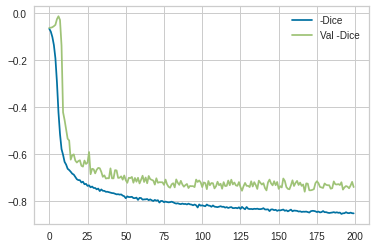

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++


In [ ]:
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score,roc_auc_score,confusion_matrix,recall_score
from joblib import dump
import pandas as pd
import os

EPOCHS = 200
BATCH_SIZE = batch_size

a = 1
# phi_units = 16
metrics = [iou, dice_coef, sensitivity, specificity, 'binary_accuracy']

excel_write = pd.ExcelWriter('results.xlsx')

for phi_units in [1]:
  results_template = 'results_a-{}_phi-units-{}' # string template
  basepath = results_template.format(a,phi_units)
  try:
    os.mkdir(basepath)
  except:
    print('File exists')

  tf.keras.backend.clear_session()

  seg_model = fcn((height,width),ch_out=3)

  seg_model.compile(optimizer=Adam(lr=1e-4),
                    loss={'output':dice_coef_loss},
                    metrics = metrics)

  callbacks = [tf.keras.callbacks.ModelCheckpoint(basepath+'/Model_Checkpoint',
                                                  monitor='val_output_loss',
                                                  verbose=0,
                                                  mode = 'min')]

  history = seg_model.fit(train_gen,
                          steps_per_epoch=len(df_train_images) // BATCH_SIZE, 
                          epochs=EPOCHS , 
                          callbacks=callbacks,
                          validation_data = val_gen,
                          validation_steps=len(df_val_images) // BATCH_SIZE)

  # seg_model = tf.keras.Model(inputs = [seg_model.input],outputs=[seg_model.output[0]])


  plt.plot(history.history['loss'],label = '-Dice')
  plt.plot(history.history['val_loss'],label = 'Val -Dice')
  plt.legend()
  plt.savefig(basepath+'/LearningCurve.png')
  plt.show()


  seg_model.save(basepath+'/model.h5')
  ## Calculo de metricas de rendimiento. 


  filesname = df_test_images['filepath'].to_list()
  masks_files = df_test_images['mask'].to_list()
  # test_t = df_test_images['nerve_name'].to_list()
  template = 'there is nerve: {}\t Dice: {}\t AUC: {}'
  Acc = []
  Dice = []
  GM = []
  Sen = []
  Spe = []
  AUC = []
  CM = []
  there_is_nerve = []
  show = True
  for path_file,mask_file in zip(filesname,masks_files):
    image1 = cv2.resize(cv2.imread(path_file),(height,width))
    mask = cv2.resize(cv2.imread(mask_file,0),(height,width)).reshape(-1,)
    if mask.sum()==0:
      there_is_nerve.append(False)
    else:
      there_is_nerve.append(True)
      mask = mask/mask.max()
      mask[mask >= 0.5] = 1.
      mask[mask <0.5] = 0.
      if show:
        print('+++++++++++++++++++++++++++++++++++++')
        print(np.unique(mask))
        print('+++++++++++++++++++++++++++++++++++++')
        show = False
    # print(np.unique(mask))
    mask_est = np.squeeze(seg_model.predict(np.expand_dims(image1,0)/255)[0,:,:,:].astype(np.uint8)).reshape(-1,)
    CM.append(confusion_matrix(mask,mask_est,labels=[0,1]))
    Acc.append(accuracy_score(mask,mask_est))
    sen = recall_score(mask,mask_est,pos_label=1,zero_division=0)
    spe = recall_score(mask,mask_est,pos_label=0,zero_division=0)
    Sen.append(sen)
    Spe.append(spe)
    GM.append(sqrt(sen*spe))
    Dice.append(f1_score(mask,mask_est,pos_label=1,zero_division=0))
    try:
      AUC.append(roc_auc_score(mask,mask_est))
    except:
      AUC.append('null')

  mdict = {'Acc':Acc,
          'GM': GM,
          'Dice':Dice,
          'AUC':AUC,
          'Sen':Sen,
          'Spe':Spe,}

  pd.DataFrame(mdict).to_excel(excel_write,sheet_name='a-{}__phi-{}'.format(a,phi_units))

  # plt.boxplot([Acc,GM,Dice,Sen,Spe,AUC])
  # plt.xticks([1,2,3,4,5,6],['Acc','GM','Dice','Sen','Spe','AUC'])
  # plt.savefig(basepath+'/Boxplot_all')
  # plt.show()

  # for name_nerve in ['ciatico','cubital','femoral','mediano']:
  #   Acc_aux = [Acc[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   Sen_aux = [Sen[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   Spe_aux = [Spe[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   Dice_aux = [Dice[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   GM_aux = [GM[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   AUC_aux = [AUC[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  # plt.boxplot([Acc,GM,Dice,Sen,Spe,AUC])
  # plt.xticks([1,2,3,4,5,6],['Acc','GM','Dice','Sen','Spe','AUC'])
  # plt.title(name_nerve)
  # plt.savefig(basepath+'/Boxplot')
  # plt.show()

  savedata = {'Acc':Acc,
              'GM':GM,
              'Dice':Dice,
              'Sen':Sen,
              'Spe':Spe,
              'AUC':AUC,
              'CM':CM,
              'train':df_train_images.to_dict(),
              'test':df_test_images.to_dict(),
              'val':df_val_images.to_dict()}
  dump(savedata,basepath+'/results.joblib')

excel_write.save()


In [ ]:
!zip -r results_FCN results* results.xlsx

  adding: results_a-1_phi-units-1/ (stored 0%)
  adding: results_a-1_phi-units-1/Model_Checkpoint/ (stored 0%)
  adding: results_a-1_phi-units-1/Model_Checkpoint/assets/ (stored 0%)
  adding: results_a-1_phi-units-1/Model_Checkpoint/keras_metadata.pb (deflated 94%)
  adding: results_a-1_phi-units-1/Model_Checkpoint/saved_model.pb (deflated 90%)
  adding: results_a-1_phi-units-1/Model_Checkpoint/variables/ (stored 0%)
  adding: results_a-1_phi-units-1/Model_Checkpoint/variables/variables.index (deflated 76%)
  adding: results_a-1_phi-units-1/Model_Checkpoint/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: results_a-1_phi-units-1/LearningCurve.png (deflated 4%)
  adding: results_a-1_phi-units-1/results.joblib (deflated 70%)
  adding: results_a-1_phi-units-1/model.h5 (deflated 9%)
  adding: results_a-1_phi-units-8/ (stored 0%)
  adding: results.xlsx (deflated 2%)
